In [ ]:
! pip install ripser persim

In [79]:
import ripser, persim, warnings
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from functools import partial

## Function that returns bottleneck distance and optionally plots persistence diagram matchings

In [80]:
def getDist(feature, homologyGroup, matching=False, dgm=False):
  '''
  Takes a 2D array with columns x,y
  and integer for homology group
  TODO: accept 3D time series
  '''
                  # Line has same width and number of X points as feature...          but with y values at zero
  line = np.array([np.linspace(min(feature[:,0]),max(feature[:,0]),len(feature[:,0])),np.zeros_like(feature[:,1])])
  feature_dgm = ripser.ripser(feature)['dgms'][homologyGroup]
  line_dgm = ripser.ripser(line.T)['dgms'][homologyGroup]

  # Ignore warnings for dgm with non-finite death times
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=r"dgm[12] has points with non-finite death times;ignoring those points")
    if dgm:
      persim.bottleneck_matching(feature_dgm, line_dgm, persim.bottleneck( \
        feature_dgm, line_dgm, matching=True)[1], labels=['feature', 'line'])

    if matching:
      return feature_dgm, line_dgm, persim.bottleneck(feature_dgm, line_dgm, matching=True)[1]
    else:
      return persim.bottleneck(feature_dgm, line_dgm)

## Helper functions for bugfixing and parallelization

In [81]:
def setupBuff(data):
  '''
  Since we have periodic boundary conditions, we need copy the point cloud on
  each end of the domain before looping over the original middle section
  * time, timeRange are not included in this function *
  '''
  if data.ndim==2:
    x,y = data.T
    xRange = x.max() - x.min()
    lbuff, rbuff = data.copy(), data.copy()
    lbuff[:, 0] -= xRange
    rbuff[:, 0] += xRange
    buff = np.vstack((lbuff, data, rbuff))
  elif data.ndim==3:
    # Assumes dims are time,x,y
    x, y = data.reshape(data.shape[1]*data.shape[2],2).T
    xRange = x.max() - x.min()
    buff = np.zeros((data.shape[1]*data.shape[2],2))
    buffx,buffy = buff.T
    for t in range(data.shape[0]):
      lbuff, rbuff = data[t].copy(), data[t].copy()
      lbuff[:, 0] -= xRange
      rbuff[:, 0] += xRange
      buff[t*data.shape[1]:(t+1)*data.shape[1]] = np.vstack((lbuff, data[t], rbuff))
  #buffx,buffy = buff.T
  return x, y, xRange, buff#, buffx, buffy

                                        # 2D is default
def getWindow(pos, offset, buff, time=None, tPos=None, tOffset=None):
  buffx = buff.T[0]
  if data.ndim==2:
    window = buff[(buffx>pos-offset) & (buffx<pos+offset)]
    # Try to prevent 1-cell disconnected components on the edges
    # This is a rare edge case - this mostly doesn't do anything
    # Doesn't seem to matter for homology groups greater than zero
    window[:,1][window[:,0]==window[0,0]] = window[0,1].min()
    window[:,1][window[:,0]==window[-1,0]] = window[-1,1].min()
  elif data.ndim==3:
    raise ValueError("Windows for 3D time series not yet implemented")
    # TODO: figure out how to select 3D window
    window = buff[(buffx>pos-offset) & (buffx<pos+offset)]
    # Try to prevent 1-cell disconnected components on the edges
  return window

def distsAtPos(pos, offsets, homologyGroups, buff):
  '''
  Gets bottleneck distances at an alongshore position given window offsets, homology groups, and buffered data
  '''
  print(pos, flush = True)
  # Each parallel job will return a row of bottleneck distances for all offsets and homology groups
  posDists = np.zeros((len(offsets), len(homologyGroups)))
  for offsetIdx, offset in enumerate(offsets):
    # TODO : 3D case
    window = getWindow(pos, offset, buff)
    for hgIdx,hg in enumerate(homologyGroups):
        posDists[offsetIdx,hgIdx] = getDist(window, hg)
  # Be careful of this indent! Otherwise it will return only the first offset
  return posDists

## Function that loops over data and stores bottleneck distances in a higher order array

In [82]:
def sliding_windows_par(pointCloud, homologyGroups=None, dx=None, maxWindow=None, minWindow=None, step=None):
  '''
  Accepts 2D snapshots
  TODO: accept 3D time series
  When this is done, each alongshore position has a spectrum of bottleneck
    distances for a range of window sizes centered on those positions
  '''
  x, y, xRange, buff = setupBuff(pointCloud)
  if pointCloud.ndim==3:
    # Create array of timestep values for each x,y row in buff
           # TODO: Use absolute units: time*dt+startTime
    time = np.repeat(range(pointCloud.shape[0]),pointCloud.shape[1])
    timeRange = time.max() - time.min()

  # Prefer input parameters. Defaults are maximum range and resolution (slow).
  if homologyGroups is None:
    homologyGroups = list(range(pointCloud.ndim))
  if dx is None:
    dx = np.diff(x)[np.diff(x)>0].min() # cell size
  # how much to increment between adjacent window sizes
  if step is None:
    step = dx
  # window widths
  if maxWindow is None:
    maxWindow = xRange
  if minWindow is None:
    minWindow = step   # Anything higher creates an arbitrary cutoff

  # I *think* these are correct... but don't sue me
  positions = dx*np.arange(xRange//dx+2)+x.min()
  offsets = step*np.arange(1,maxWindow//step+1)/2
  offsets = offsets[offsets>=minWindow/2]

  print(f"Positions: {positions}")
  print(f"Offsets: {offsets}")
  print(f"Homology Groups: {homologyGroups}")

  # Create a partial function for distsAtPos with fixed arguments
  distsAtPos_partial = partial(distsAtPos, offsets=offsets, homologyGroups=homologyGroups, buff=buff)

  # Execute the inner loop in parallel for each position
  # The results will be a list of arrays, where each array corresponds to a column of 'dists'
  # Parallel() and delayed() each return a function called by Parallel()() and delayed()()
  allPosDists = Parallel(n_jobs=-1, backend='threading')( # -1 means all; backend='threading' necessary for print (at least in colab)
      # delayed() parallelizes the list comprehension (can't just unpack args, expects multiple calls)
      delayed(distsAtPos_partial)(pos) for pos in positions)

  # Reshape the results into the final dists array
  # allPosDists is a list of arrays, each array is (len(offsets), len(homologyGroups))
  # Need (len(homologyGroups), len(offsets), len(positions)))
  # Rearrange dists dims so that homology group is outermost
  dists = np.array(allPosDists).transpose(2,1,0) # Idk why this is different from non-parallel dists

  return dists, positions, offsets*2, homologyGroups

## Functions for plotting heatmaps

In [83]:
def plot_heatmap(dists, homologyGroup, positions, sizes, maxY, minY, hspace=-1):
  fig, (ax1, ax2) = plt.subplots(2, 1)

  # Plot the heatmap
  dx = positions[1]-positions[0]
  step = sizes[1]-sizes[0]
  extent = [positions[0]-dx/2, positions[-1]+dx/2, sizes[0]-step, sizes[-1]]
  im = ax1.imshow(dists[homologyGroup], aspect='auto', origin='lower', extent=extent)
  fig.colorbar(im, ax=ax1, label=f"Bottleneck Distance for Homology Group {homologyGroup}", orientation='horizontal', location='top', aspect=50)
  ax1.set_ylabel('Window Size')
  ax1.set_aspect('equal', adjustable='box')
  # ax1.set_xlim(data[:,0].min(), positions.max()) # Ensure x-axis matches scatter plot
  ax1.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off

  # Plot the original data
  ax2.scatter(*data.T, s=1) #*setupBuff(data)[3].T, <- Not clear that it's the whole domain
  ax2.set_xlabel('Position')
  ax2.set_ylabel('Y')
  ax2.set_aspect('equal', adjustable='box')
  ax2.set_xlim(*extent[:2]) # Set x-axis to match heatmap
  scatpad = (maxY-minY)/20
  ax2.set_ylim([minY-scatpad,maxY+scatpad]) # Set y-axis to max across time

  # This is related to maxY-minY and len(sizes); 8:-0.75
  plt.subplots_adjust(hspace=hspace)
  plt.tight_layout()
  plt.show()

def printDists(hg, dists, homologyGroups):
  np.set_printoptions(linewidth=200, precision=2, suppress=True, formatter={'float': '{: 0.2f}'.format})
  print(f"\nHomology Group: {homologyGroups[homologyGroups.index(hg)]}")
  print(np.flipud(dists[hg]))

def printAndPlot(dists, homologyGroups, positions, sizes, maxY, minY, hspace=-1):
  for hg in homologyGroups:
    printDists(hg, dists, homologyGroups)
    plot_heatmap(dists, hg, positions, sizes, maxY, minY, hspace=hspace)

## Read in data

In [ ]:
!git clone https://github.com/dmcdoug/Topology-of-Shoreline-Features.git
!mv Topology-of-Shoreline-Features/data .

In [85]:
# Manually digitized natural features
spit = np.loadtxt('data/spit.txt')
cape = np.loadtxt('data/cape.txt')
inlet = np.loadtxt('data/inlet.txt')

# Video data - contains irregular numbers of points,
# so the whole thing won't work in numpy
coasts = dict()
for fnum in range(1,6):
    fnBase = f"jgrf217-sup-000{fnum+1}-ms0{fnum}"
    readin = np.load(f"data/{fnBase}_noPonds.npz")
    coasts[fnBase] = [readin[key] for key in readin.keys()]
    readin.close()
videoNum = 0
timestep = -1
# Returns 2D point cloud x,y
data = coasts[list(coasts.keys())[videoNum]][timestep]

## Run sliding windows

Positions: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
Offsets: [ 25.00  50.00  75.00  100.00]
Homology Groups: [0, 1]
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800

Shape: (2, 4, 17)

Homology Group: 0
[[ 1.12  1.00  1.00  1.00  0.50  0.42  1.50  1.50  1.50  1.50  0.42  0.42  0.41  1.12  1.12  1.12  1.12]
 [ 4.12  1.00  1.00  9.00  0.42  0.43  1.50  1.50  1.50  0.43  0.42  0.41  0.41  4.47  1.12  1.12  4.12]
 [ 1.00  1.00  1.00  0.49  0.42  0.42  0.42  1.50  1.50  0.43  0.42  0.41  0.41  0.41  1.12  1.12  1.00]
 [ 1.00  2.06  9.00  0.41  0.43  0.41  0.43  1.50  0.43  0.43  0.41  0.41  0.41  0.41  4.47  4.12  1.00]]


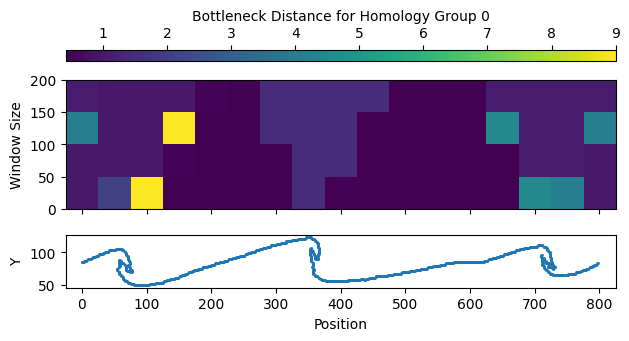


Homology Group: 1
[[ 1.42  1.42  1.42  1.42  0.00  0.00  0.62  0.62  0.62  0.62  0.00  0.00  0.00  0.50  0.50  0.50  1.42]
 [ 0.43  1.42  1.42  0.00  0.00  0.00  0.62  0.62  0.62  0.00  0.00  0.00  0.00  0.34  0.50  0.50  1.42]
 [ 0.00  1.42  1.42  0.00  0.00  0.00  0.00  0.62  0.62  0.00  0.00  0.00  0.00  0.00  0.50  0.50  0.00]
 [ 0.00  0.43  0.00  0.00  0.00  0.00  0.00  0.62  0.00  0.00  0.00  0.00  0.00  0.00  0.34  0.00  0.00]]


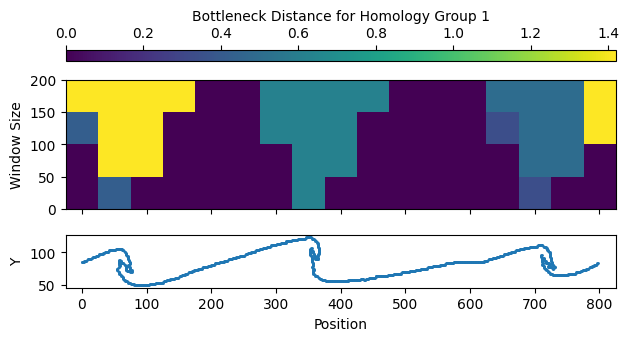

In [86]:
videoNum = -1
timestep = -1
thisCoast = coasts[list(coasts.keys())[videoNum]]
maxY1 = max([max(slice[:,1]) for slice in thisCoast])
minY1 = min([min(slice[:,1]) for slice in thisCoast])
data = thisCoast[timestep] # Returns 2D point cloud x,y
                                                               # Fast: 100                     50
dists1, positions, sizes, homologyGroups = sliding_windows_par(data, dx=50, maxWindow=200, step=50)
print(f"\nShape: {dists1.shape}")
printAndPlot(dists1, homologyGroups, positions, sizes, maxY1, minY1)

Positions: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
Offsets: [ 25.00  50.00  75.00  100.00]
Homology Groups: [0, 1]
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800

Shape: (2, 4, 17)

Homology Group: 0
[[ 0.48  0.48  1.00  1.00  1.00  1.00  1.00  0.42  0.42  0.45  0.47  0.47  0.47  0.46  0.48  0.47  0.48]
 [ 0.48  0.49  1.00  1.00  1.00  1.00  1.00  0.41  0.43  0.46  0.46  0.48  0.46  0.48  0.47  0.48  0.48]
 [ 0.48  0.43  0.41  1.00  1.00  1.00  0.41  0.41  0.42  0.43  0.47  0.51  0.47  0.43  0.45  0.49  0.48]
 [ 1.00  0.41  0.41  1.00  1.00  1.00  0.41  0.41  0.41  0.45  0.51  0.41  0.53  0.43  0.47  0.49  0.47]]


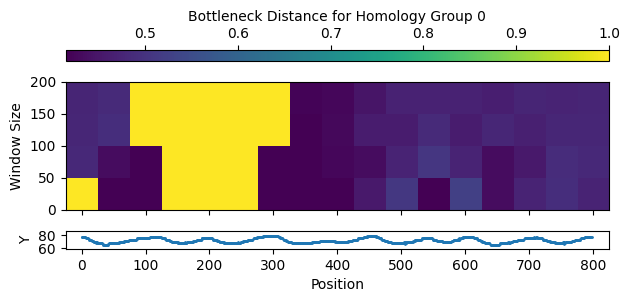


Homology Group: 1
[[ 0.41  0.41  0.29  0.29  0.29  0.29  0.00  0.00  0.00  0.41  0.41  0.41  0.41  0.29  0.41  0.41  0.41]
 [ 0.41  0.00  0.29  0.29  0.29  0.00  0.00  0.00  0.00  0.41  0.41  0.41  0.29  0.29  0.41  0.41  0.41]
 [ 0.41  0.00  0.00  0.29  0.29  0.00  0.00  0.00  0.00  0.00  0.41  0.41  0.29  0.00  0.29  0.41  0.41]
 [ 0.00  0.00  0.00  0.29  0.00  0.00  0.00  0.00  0.00  0.00  0.41  0.00  0.29  0.00  0.29  0.41  0.00]]


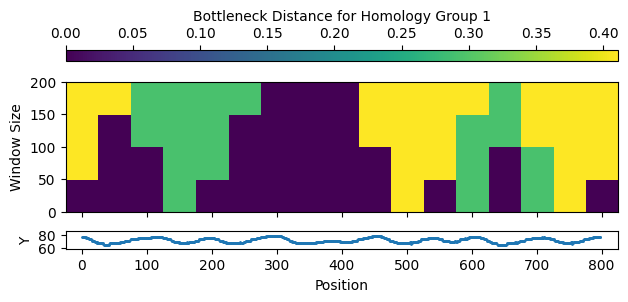

In [87]:
videoNum = 0
timestep = 150#-1
thisCoast = coasts[list(coasts.keys())[videoNum]]
maxY2 = max([max(slice[:,1]) for slice in thisCoast])
minY2 = min([min(slice[:,1]) for slice in thisCoast])
data = thisCoast[timestep] # Returns 2D point cloud x,y
                                                               # Fast: 100                     50
dists2, positions, sizes, homologyGroups = sliding_windows_par(data, dx=50, maxWindow=200, step=50)
print(f"\nShape: {dists2.shape}")
printAndPlot(dists, homologyGroups, positions, sizes, maxY2, minY2, hspace=-1.1)

## Investigating bugs
* I think we need to move the window along the consecutive cells, not across X values
* Why does it seem like the buffer isn't working?? The sandwaves case shouldn't be different on the edges
  * After checking other timesteps, I think it is working - it just looks symmetrical because there's something wrong with the periodic boundaries and the waves relax to be more regular mid-domain


#### Below is an example of how to get bottleneck matching persistence diagrams for a point cloud

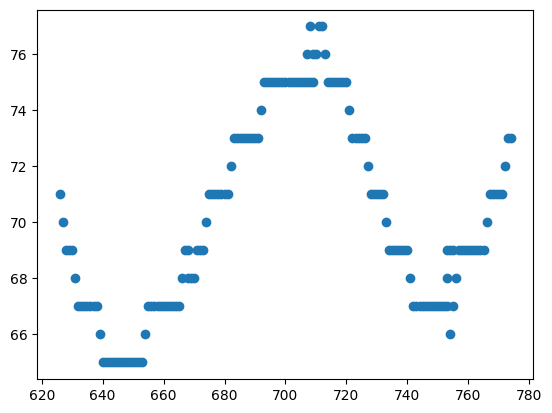

Bottleneck distance for homology group 0: 0.465


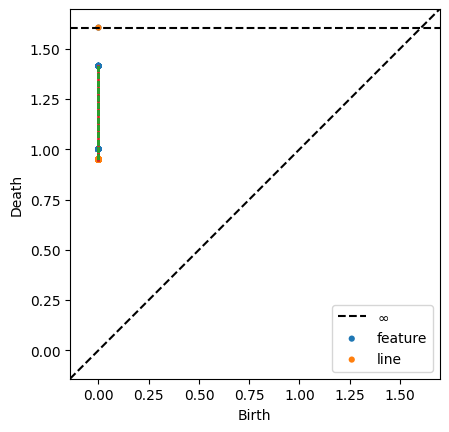

Bottleneck distance for homology group 1: 0.411


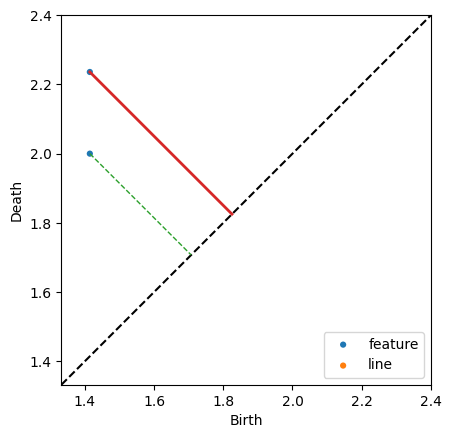

In [88]:
pos,offset = 700,75
window = getWindow(pos, offset, setupBuff(data)[3]) # You can probably just use data for most windows (small and mid-domain)
plt.scatter(*window.T)
plt.show()
for hg in range(data.ndim):
  print(f"Bottleneck distance for homology group {hg}: {getDist(window, hg, dgm=True):.3f}")
  plt.show()

Looks like we need to select the minimum of the outermost cell in each window to prevent 1-cell disconnected components on the edges of some windows.

Implemented. This is a rare edge case - this mostly doesn't do anything. Doesn't seem to matter for homology groups greater than zero

It sometimes helps for the sandwaves; spits still need window to move along consecutive points

## Ideas for more plots

IF WE HAVE 3 HOMOLOGY GROUPS WE CAN MAKE RGB MOVIES OF THE BOTTLENECK DISTANCES CHANGING OVER TIME!!!

This will only work with a single window size for time at each timestep

For now, try animating plot_heatmap()

Can I increase step and dx to reduce the number of positions and offsets to save computation time?
I don't think so, they are about half the size of the patterns (nyquist frequency), so if step and dx were any larger we could see anomalies but not trends.
Actually, doubling step to 50 (4 sizes) works fine! 3 is fine too but much less impressive

I think the actual dx is 100m. Should probably go back and change in the video processing notebook and the data files. Or is it better to use 0-indexed integers for axes in math?

Are the data files even accurate? dy looks larger than dx. Need to check the ashton paper for dx,dy,dt and size of domain. If these data files are bad, need to regenerate from new model runs :( Probably won't do this for the class project...

Not in this notebook: Make a figure with 8 subplots for the pretty argmax plots stacked over the noPonds scatterplots of the final frame of each video

## Below are some drafts for getting started with animation
The first one is from an unrelated notebook

The latter ones are from Gemini AI

In [ ]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
from matplotlib.animation import FuncAnimation, PillowWriter
class PillowWriterNG(PillowWriter):
    def finish(self):
            self._frames[0].save(
                self.outfile, save_all=True, append_images=self._frames[1:],
                duration=int(1000 / self.fps), loop=None)

fig=plt.figure(figsize=(10, 4))
fig.set_constrained_layout(True)
plt.axis([42, 130, -1, 8])
plt.axhline(0,color='grey')
plt.grid()
time = this.time.values[0]
line2D = this.sel(time=time).elevation.plot(figure=fig)[0]
ttl = plt.title(time)
def update(time):
    line2D.set_ydata(this.sel(time=time).elevation.values)
    ttl.set_text(time)
    return [line2D, ttl]
anim = FuncAnimation(fig, update, this.time.values[1:], blit=True, repeat=False)
anim
anim.save(f"{time1}_QC{QC}.gif", writer="pillow")#PillowWriterNG())

In [ ]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
class PillowWriterNG(PillowWriter):
    def finish(self):
            self._frames[0].save(
                self.outfile, save_all=True, append_images=self._frames[1:],
                duration=int(1000 / self.fps), loop=None)

# Choose a homology group to animate (e.g., 0 for connected components, 1 for loops)
hg_to_animate = 0 # Change this to 1 to animate for the other homology group

# Assuming thisCoast, maxY1, minY1 are already defined from previous cells (videoNum = -1)
# If you wish to animate a different video, you can change `videoNum` here.
videoNum = -1
thisCoast = coasts[list(coasts.keys())[videoNum]]

# Calculate maxY and minY across ALL timesteps in thisCoast for consistent scatter plot limits
maxY = max([data_slice[:,1].max() for data_slice in thisCoast])
minY = min([data_slice[:,1].min() for data_slice in thisCoast])

# Use the same parameters for sliding_windows_par as in the last execution
dx_val = 50
maxWindow_val = 200
step_val = 50

all_dists_per_timestep = []
all_positions_per_timestep = []
homology_groups_constant = None

print("Starting pre-computation for animation...")
for i, data_timestep in enumerate(thisCoast):
    print(f"Processing timestep {i+1}/{len(thisCoast)}", flush=True)
    dists_i, positions_i, sizes_i, homologyGroups_i = sliding_windows_par(
        data_timestep, dx=dx_val, maxWindow=maxWindow_val, step=step_val
    )
    all_dists_per_timestep.append(dists_i)
    all_positions_per_timestep.append(positions_i)
    if homology_groups_constant is None:
        homology_groups_constant = homologyGroups_i
    # sizes_i should be constant based on fixed step and maxWindow, so we only need to store it once
    if i == 0:
        sizes_constant = sizes_i

print("Pre-computation complete.")

# Convert lists to arrays for easier indexing
# Shape: (num_timesteps, num_homology_groups, num_offsets, num_positions)
all_dists_per_timestep = np.array(all_dists_per_timestep)
# Shape: (num_timesteps, num_positions)
all_positions_per_timestep = np.array(all_positions_per_timestep)

# Setup the figure and initial plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Initial data for the first frame
initial_dists = all_dists_per_timestep[0, hg_to_animate]
initial_positions = all_positions_per_timestep[0]
initial_data = thisCoast[0]

# Calculate extent for imshow (y-axis is constant, x-axis varies per frame)
step_y_extent = sizes_constant[1] - sizes_constant[0] if len(sizes_constant) > 1 else sizes_constant[0]
y_extent = [sizes_constant[0] - step_y_extent, sizes_constant[-1]]

# The x-extent will be set per frame, but for initial plot we use the first frame's positions
dx_initial = initial_positions[1] - initial_positions[0]
x_extent_initial = [initial_positions[0] - dx_initial / 2, initial_positions[-1] + dx_initial / 2]
initial_extent = x_extent_initial + y_extent

im = ax1.imshow(initial_dists, aspect='auto', origin='lower', extent=initial_extent,
                vmin=0, vmax=all_dists_per_timestep[:, hg_to_animate].max())
fig.colorbar(im, ax=ax1, label=f"Bottleneck Distance for Homology Group {homology_groups_constant[hg_to_animate]}", orientation='horizontal', location='top', aspect=50)
ax1.set_ylabel('Window Size')
ax1.set_title(f'Homology Group {homology_groups_constant[hg_to_animate]} - Timestep 1')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

sc = ax2.scatter(initial_data[:,0], initial_data[:,1], s=1)
ax2.set_xlabel('Position')
ax2.set_ylabel('Y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(*x_extent_initial)
scatpad = (maxY - minY) / 20
ax2.set_ylim([minY - scatpad, maxY + scatpad])

hspace_val = -1.1 # As used in printAndPlot
plt.subplots_adjust(hspace=hspace_val)
plt.tight_layout()

# Update function for the animation
def update(frame):
    # Get pre-computed data for the current frame
    dists_frame = all_dists_per_timestep[frame, hg_to_animate]
    positions_frame = all_positions_per_timestep[frame]
    data_frame = thisCoast[frame]

    # Update heatmap
    im.set_data(dists_frame)
    # Update x-extent for heatmap (y-extent is constant)
    dx_frame = positions_frame[1] - positions_frame[0]
    x_extent_frame = [positions_frame[0] - dx_frame / 2, positions_frame[-1] + dx_frame / 2]
    current_extent = x_extent_frame + y_extent
    im.set_extent(current_extent)

    # Update scatter plot
    sc.set_offsets(data_frame)
    ax2.set_xlim(*x_extent_frame) # Ensure x-axis of scatter plot matches heatmap
    ax1.set_title(f'Homology Group {homology_groups_constant[hg_to_animate]} - Timestep {frame + 1}')

    return [im, sc, ax1.title]

# Create the animation
anim = FuncAnimation(fig, update, frames=len(thisCoast), interval=200, blit=True)

# Display the animation (Colab will render this automatically if %matplotlib inline and jshtml is set)
anim

The cell above mistakenly changes x extent on every timestep. The cell below fixes that but Gemini also changed a bunch of other stuff...

In [ ]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
class PillowWriterNG(PillowWriter):
    def finish(self):
            self._frames[0].save(
                self.outfile, save_all=True, append_images=self._frames[1:],
                duration=int(1000 / self.fps), loop=None)

# Choose a homology group to animate (e.g., 0 for connected components, 1 for loops)
hg_to_animate = 0 # Change this to 1 to animate for the other homology group

# If you wish to animate a different video, you can change `videoNum` here.
videoNum = 5
noPondsStr = "_noPonds" # set to empty to use full point cloud

fnBase = f"jgrf217-sup-000{videoNum+1}-ms0{videoNum}{noPondsStr}"
readin = np.load(f"data/{fnBase}.npz")
thisCoast = [readin[key] for key in readin.keys()]
readin.close()

# Calculate maxY and minY across all timesteps in thisCoast for consistent scatter plot limits
maxY = max([data_slice[:,1].max() for data_slice in thisCoast])
minY = min([data_slice[:,1].min() for data_slice in thisCoast])

# Calculate global min/max x for `thisCoast` to define constant x-axis for animation
global_min_x = min([data_slice[:,0].min() for data_slice in thisCoast])
global_max_x = max([data_slice[:,0].max() for data_slice in thisCoast])
global_x_range = global_max_x - global_min_x

# Define constant positions and offsets based on the global x-range
positions_constant = dx_val * np.arange(global_x_range // dx_val + 2) + global_min_x
offsets_constant = step_val * np.arange(1, maxWindow_val // step_val + 1) / 2
offsets_constant = offsets_constant[offsets_constant >= minWindow_val / 2]
sizes_constant = offsets_constant * 2

# Use the same parameters for sliding_windows_par as in the last execution
dx_val = 50
maxWindow_val = 200
step_val = 50
minWindow_val = step_val # Default from sliding_windows_par

# Homology groups are constant (0 and 1 for 2D data)
homology_groups_constant = [0, 1]

all_dists_per_timestep = []

print("Starting pre-computation for animation...")
for i, data_timestep in enumerate(thisCoast):
    print(f"Processing timestep {i+1}/{len(thisCoast)}", flush=True)

    # Setup buffer for the current timestep's data
    _, _, _, buff_i = setupBuff(data_timestep)

    # Create a partial function for distsAtPos with fixed arguments (buff_i is specific to this timestep)
    distsAtPos_partial = partial(distsAtPos, offsets=offsets_constant, homologyGroups=homology_groups_constant, buff=buff_i)

    # Execute in parallel for each position_constant
    allPosDists_i = Parallel(n_jobs=-1, backend='threading')(
        delayed(distsAtPos_partial)(pos) for pos in positions_constant)

    # Reshape the results into the final dists array
    dists_i = np.array(allPosDists_i).transpose(2,1,0) # (num_homology_groups, num_offsets, num_positions)
    all_dists_per_timestep.append(dists_i)

print("Pre-computation complete.")

# Convert list to array for easier indexing
# Shape: (num_timesteps, num_homology_groups, num_offsets, num_positions)
all_dists_per_timestep = np.array(all_dists_per_timestep)

np.savez_compressed(f"{fnBase}_dists.npz", dists=all_dists_per_timestep, \
                    positions=positions_constant, sizes=sizes_constant, \
                    homologyGroups=homology_groups_constant, minY, maxY)

# Setup the figure and initial plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Calculate constant x-extent for the heatmap and scatter plot
dx_constant = positions_constant[1] - positions_constant[0]
x_extent_constant = [positions_constant[0] - dx_constant / 2, positions_constant[-1] + dx_constant / 2]

# Calculate extent for imshow (y-axis is constant, x-axis is now also constant)
step_y_extent = sizes_constant[1] - sizes_constant[0] if len(sizes_constant) > 1 else sizes_constant[0] # Handle single window size case
y_extent = [sizes_constant[0] - step_y_extent, sizes_constant[-1]]
constant_extent = x_extent_constant + y_extent

# Initial data for the first frame
initial_dists = all_dists_per_timestep[0, hg_to_animate]
initial_data = thisCoast[0]

im = ax1.imshow(initial_dists, aspect='auto', origin='lower', extent=constant_extent,
                vmin=0, vmax=all_dists_per_timestep[:, hg_to_animate].max())
fig.colorbar(im, ax=ax1, orientation='horizontal', location='top', aspect=50) #label=f"Bottleneck Distance for Homology Group {homology_groups_constant[hg_to_animate]}",
ax1.set_ylabel('Window Size')
ax1.set_title(f'Homology Group {homology_groups_constant[hg_to_animate]} - Timestep 1')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

sc = ax2.scatter(initial_data[:,0], initial_data[:,1], s=1)
ax2.set_xlabel('Position')
ax2.set_ylabel('Y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(*x_extent_constant) # Use the constant x-extent
scatpad = (maxY - minY) / 20
ax2.set_ylim([minY - scatpad, maxY + scatpad])

hspace_val = -1.1 # As used in printAndPlot
plt.subplots_adjust(hspace=hspace_val)
plt.tight_layout()

# Update function for the animation
def update(frame):
    # Get pre-computed data for the current frame
    dists_frame = all_dists_per_timestep[frame, hg_to_animate]
    data_frame = thisCoast[frame]

    # Update heatmap
    im.set_data(dists_frame)
    im.set_extent(constant_extent) # Use the constant extent

    # Update scatter plot
    sc.set_offsets(data_frame)
    ax2.set_xlim(*x_extent_constant) # Ensure x-axis of scatter plot matches heatmap (constant)
    ax1.set_title(f'Homology Group {homology_groups_constant[hg_to_animate]} - Timestep {frame + 1}')

    return [im, sc, ax1.title]

# Create the animation
anim = FuncAnimation(fig, update, frames=len(thisCoast), interval=200, blit=True)

anim.save(f"{fnBase}_H{hg_to_animate}.gif", writer="pillow")#PillowWriterNG())

# Display the animation (Colab will render this automatically if %matplotlib inline and jshtml is set)
anim
